In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import seaborn as sns

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print mnist.train.labels
print mnist.train.images
image_width = 28

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [2]:
%autosave 30
%matplotlib inline

Autosaving every 30 seconds


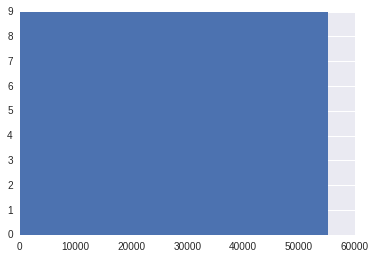

In [3]:
plt.plot(np.argmax(mnist.train.labels, axis = 1))
plt.show()

In [4]:
indices = list(range(len(mnist.train.labels)))
random.seed(0)
random.shuffle(indices)

(28, 28, 1)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 54999 + 1) instead


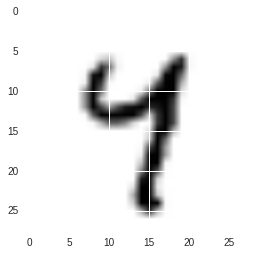

4


In [59]:
def get_corrupt_labels(fraction_corrupt):
    random.seed(0)
    corruped_labels = np.copy(mnist.train.labels)
    num_corrupt = int(fraction_corrupt * len(corruped_labels))
    for i in range(num_corrupt):
        correct_label = np.argmax(mnist.train.labels[i])
        choices = list(range(10))
        choices.remove(correct_label)
        choice = random.choice(choices)
        corruped_labels[i] = np.zeros_like(corruped_labels[i])
        corruped_labels[i][choice] = 1
    return corruped_labels
def get_batch(images, labels, n):
    indices = np.random.random_integers(0, high = len(labels)-1, size = [n])
    image_batch = images[indices]
    labels_batch = labels[indices]
    return np.reshape(image_batch, [-1, image_width, image_width, 1]), labels_batch
    
i, l = get_batch(mnist.train.images, get_corrupt_labels(.0001), 10)
print i[0].shape
plt.imshow(np.reshape(i[0], [28,28]))
plt.show()
print np.argmax(l[0])

In [10]:
import tflearn
x = tf.placeholder(tf.float32, [None, image_width, image_width, 1])
y = tf.placeholder(tf.float32, [None, 10])

# look up a standard architecture for this

net = tflearn.layers.conv.conv_2d(x, 32, 3, activation = "relu")
net = tflearn.layers.conv.conv_2d(net, 32, 3, activation = "relu")
net = tflearn.layers.conv.max_pool_2d(net, 2)
net = tflearn.layers.conv.conv_2d(net, 32, 3, activation = "relu")
net = tflearn.layers.conv.conv_2d(net, 32, 3, activation = "relu")
net = tflearn.layers.conv.max_pool_2d(net, 2)
net = tflearn.layers.conv.conv_2d(net, 32, 3, activation = "relu")
net = tflearn.layers.conv.conv_2d(net, 32, 3, activation = "relu")
net = tflearn.layers.core.fully_connected(net, 128, activation = "relu")
net = tflearn.layers.core.fully_connected(net, 10, activation = "softmax")

loss = tflearn.objectives.categorical_crossentropy (net, y)
optimizer = tf.train.AdamOptimizer(learning_rate = .001).minimize(loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU':0})
# sess = tf.Session(config)
sess = tf.Session()



In [96]:
def evaluate_with_corrupt_labels(corrupt_labels):
    train_losses = []
    val_losses = []
    val_acc_record = []
    sess.run(init)
    for i in range(900):
        image_batch, label_batch = get_batch(mnist.train.images, corrupt_labels, batch_size)
        feed = {x: image_batch, y : label_batch}
        loss_val, _ = sess.run([loss, optimizer], feed_dict=feed)
        train_losses.append(loss_val)

        image_batch, label_batch = get_batch(mnist.test.images, mnist.test.labels, batch_size)
        feed = {x: image_batch, y : label_batch}
        loss_val, prediction = sess.run([loss, net], feed_dict=feed)
        prediction = np.argmax(prediction, axis = 1)
        label_batch = np.argmax(label_batch, axis = 1)
        num_correct = np.sum(np.equal(label_batch, prediction))
        acc = 1.0 * num_correct/batch_size
        val_acc_record.append(acc)
        val_losses.append(loss_val)
    plt.plot(val_acc_record)
    plt.show()
    final_val = np.mean(val_losses[:-200])
    final_acc = np.mean(val_acc_record[:-200])
    print "accuracy:", final_acc
    return (corruption_level, final_acc), (corruption_level, final_val), final_acc

In [66]:



num_levels = 1000
corruption_levels = []
for i in range(num_levels + 1):
    corruption_levels.append(1.0 - 1.0/num_levels * i)
corruption_levels.reverse()

batch_size = 128

accuracy_record = []
crossentropy_record = []

for corruption_level in corruption_levels:
    print str(corruption_level*100) + "% of labels incorrect"
    corrupt_labels = get_corrupt_labels(corruption_level)
    prediction = np.argmax(corrupt_labels, axis = 1)
#     print prediction
    label_batch = np.argmax(mnist.train.labels, axis = 1)
#     print label_batch
#     print np.equal(label_batch, prediction).astype(np.int32)
#     print 1.0 * np.sum(np.equal(label_batch, prediction).astype(np.int32))/len(prediction)
    train_losses = []
    val_losses = []
    val_acc_record = []
    acc_tuple, ce_tuple, final_accuracy = evaluate_with_corrupt_labels(corrupt_labels)
    
    accuracy_record.append(acc_tuple)
    crossentropy_record.append(acc_tuple)


#     plt.plot(train_losses)
#     plt.plot(val_losses)
#     plt.show()
#     plt.plot(val_acc_record)
#     plt.show()
    

0.0% of labels incorrect


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 54999 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead


accuracy: 0.957131696429
0.1% of labels incorrect
accuracy: 0.951886160714
0.2% of labels incorrect
accuracy: 0.952745535714
0.3% of labels incorrect
accuracy: 0.956785714286
0.4% of labels incorrect
accuracy: 0.955323660714
0.5% of labels incorrect
accuracy: 0.953984375
0.6% of labels incorrect
accuracy: 0.959140625
0.7% of labels incorrect
accuracy: 0.956930803571
0.8% of labels incorrect
accuracy: 0.957633928571
0.9% of labels incorrect
accuracy: 0.957421875
1.0% of labels incorrect
accuracy: 0.957901785714
1.1% of labels incorrect
accuracy: 0.954486607143
1.2% of labels incorrect
accuracy: 0.953404017857
1.3% of labels incorrect
accuracy: 0.954151785714
1.4% of labels incorrect
accuracy: 0.956808035714
1.5% of labels incorrect
accuracy: 0.958046875
1.6% of labels incorrect
accuracy: 0.954095982143
1.7% of labels incorrect
accuracy: 0.952779017857
1.8% of labels incorrect
accuracy: 0.952823660714
1.9% of labels incorrect
accuracy: 0.954296875
2.0% of labels incorrect
accuracy: 0.951

50.0% of labels incorrect


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 54999 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead


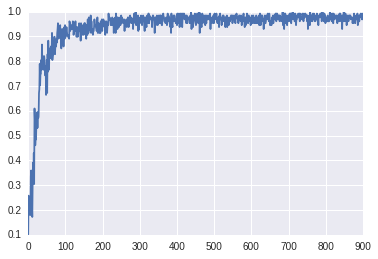

accuracy: 0.92453125
75.0% of labels incorrect


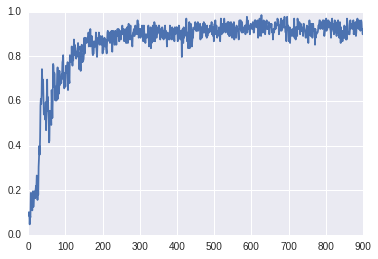

accuracy: 0.837901785714
87.5% of labels incorrect


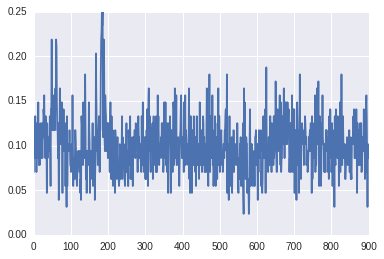

accuracy: 0.101205357143
81.25% of labels incorrect


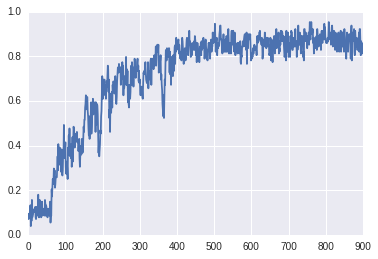

accuracy: 0.658671875
84.375% of labels incorrect


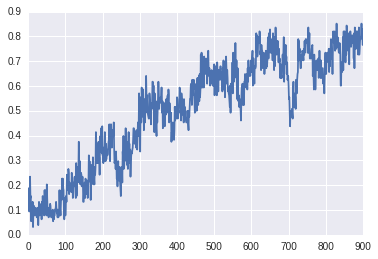

accuracy: 0.443839285714
82.8125% of labels incorrect


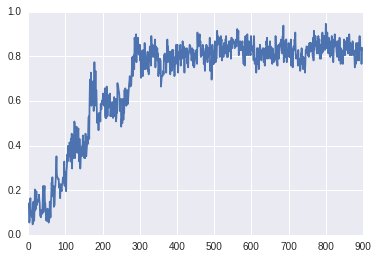

accuracy: 0.645368303571
83.59375% of labels incorrect


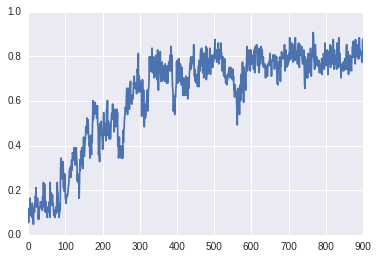

accuracy: 0.572064732143
83.984375% of labels incorrect


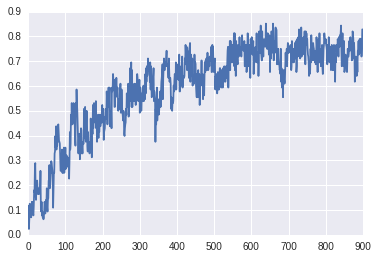

accuracy: 0.550959821429
84.1796875% of labels incorrect


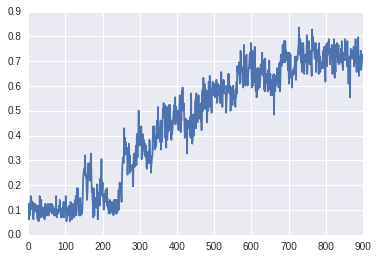

accuracy: 0.377511160714
84.08203125% of labels incorrect


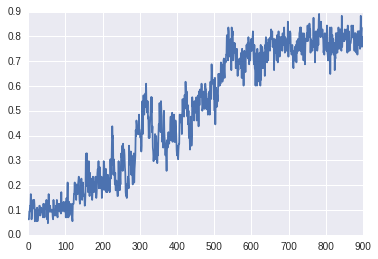

accuracy: 0.417578125
84.033203125% of labels incorrect


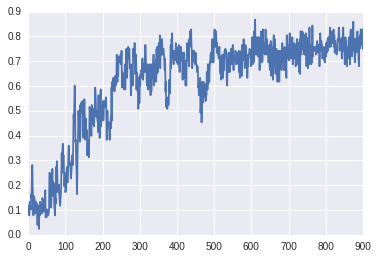

accuracy: 0.56765625
84.0576171875% of labels incorrect


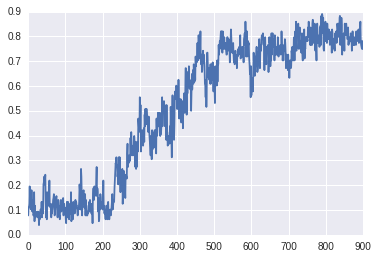

accuracy: 0.42953125


In [97]:
step = .25
corruption_level = .5
while step > .0001:
    print str(corruption_level*100) + "% of labels incorrect"
    corrupt_labels = get_corrupt_labels(corruption_level)
    prediction = np.argmax(corrupt_labels, axis = 1)
    label_batch = np.argmax(mnist.train.labels, axis = 1)

    acc_tuple, ce_tuple, final_accuracy = evaluate_with_corrupt_labels(corrupt_labels)
    if final_accuracy >= .5:
        corruption_level += step
    else:
        corruption_level -= step
    step = step / 2
    
# accuracy_record.append(acc_tuple)
# crossentropy_record.append(acc_tuple)



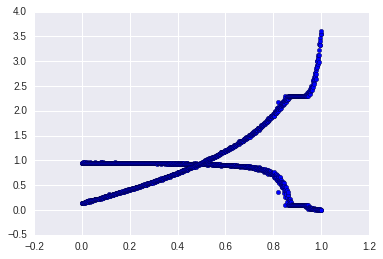

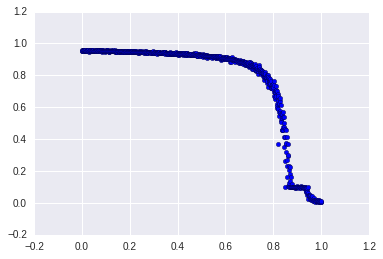

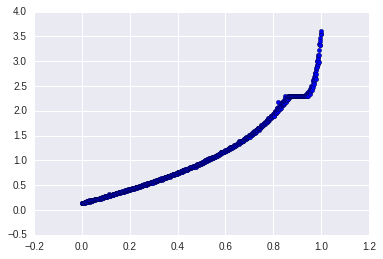

In [70]:
plt.scatter(*zip(*accuracy_record))
plt.scatter(*zip(*crossentropy_record))

plt.show()

plt.scatter(*zip(*accuracy_record))

plt.show()

plt.scatter(*zip(*crossentropy_record))
plt.show()

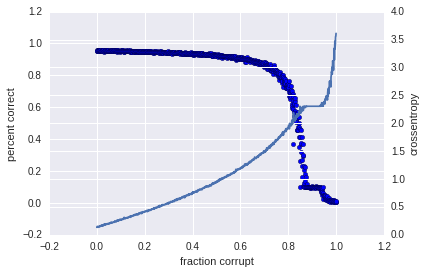

In [81]:

fig, ax1 = plt.subplots()
t = np.arange(0.01, 1.0, 0.01)
s1 = np.exp(t)
ax1.scatter(*zip(*accuracy_record))
ax1.set_xlabel('fraction corrupt')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('percent correct')



ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(*zip(*crossentropy_record))
ax2.set_ylabel('crossentropy')

plt.show()